In [34]:
from dotenv import load_dotenv

load_dotenv()

True

In [35]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o-mini')

In [36]:
import nest_asyncio

nest_asyncio.apply()

In [ ]:
import asyncio
import os

from pyzerox import zerox

# Model Setup (Use only Vision Models)
# For other providers [https://docs.litellm.ai/docs/providers]

# placeholder for additional model kwargs which might be required for some models
kwargs = {}

# system prompt to use for the vision model
custom_system_prompt = None

# to override
# custom_system_prompt = "For the below PDF page, do something..something..."

###################### OpenAI ######################
model = "gpt-4o-mini"
####################################################

# Define main async entrypoint
async def main():
    file_path = "/Users/ksj/MyProjects/llm/inflearn-langgrath-lecture/docs/income_tax.pdf"
    output_dir = "/Users/ksj/MyProjects/llm/inflearn-langgrath-lecture/docs"
    
    result = await zerox(
        file_path=file_path,
        model=model,
        output_dir=output_dir,
        custom_system_prompt=custom_system_prompt,
        select_pages=None,
        **kwargs
    )
    
    return result


# run the main function
result = asyncio.run(main())

# print markdown result
print(result)

In [14]:
import markdown
from bs4 import BeautifulSoup

file_path_markdown = "/Users/ksj/MyProjects/llm/inflearn-langgrath-lecture/docs/income_tax.md"
file_path_text = "/Users/ksj/MyProjects/llm/inflearn-langgrath-lecture/docs/income_tax.txt"

# read the Markdown file
with open(file_path_markdown, 'r', encoding='utf-8') as md_file:
    md_content = md_file.read()

# convert Markdown to HTML
html_content = markdown.markdown(md_content)

# use BeautifulSoup to extract text from HTML
soup = BeautifulSoup(html_content, 'html.parser')
text_content = soup.get_text()

# save the text to .txt file
with open(file_path_text, 'w', encoding='utf-8') as txt_file:
    txt_file.write(text_content)

print("Markdown converted to plain text successfully!")

Markdown converted to plain text successfully!


In [37]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model='text-embedding-3-large')

In [38]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1500,
    chunk_overlap = 100,
    separators=['\n\n', '\n']
)

In [ ]:
from langchain_community.document_loaders import UnstructuredMarkdownLoader

loader = UnstructuredMarkdownLoader(file_path_markdown)
documents = loader.load_and_split(text_splitter)

In [39]:
from langchain_community.document_loaders import TextLoader

loader = TextLoader(file_path_text)
documents = loader.load_and_split(text_splitter)

In [43]:
from langchain_chroma import Chroma

vector_store = Chroma.from_documents(
    documents=documents,
    embedding=embeddings,
    collection_name = 'income_tax_collections',
    persist_directory = './income_tax_collections'
)

In [44]:
retriever = vector_store.as_retriever(search_kwargs={'k': 4})

In [45]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str

In [46]:
def retrieve(state: AgentState) -> AgentState:
    """
    'retrieve' Node
    : 사용자의 질문에 기반하여, 벡터 스토어에서 관련 문서를 검색한다.

    Args:
        - state(AgentState): 사용자의 질문을 포함한 에이전트의 현재 state

    Returns:
        - AgentState: 검색된 문서가 추가된 state
    """
    
    query = state['query']
    context = retriever.invoke(query)
    
    return {'context': context}

In [47]:
from langsmith import Client

client = Client()
prompt = client.pull_prompt("rlm/rag-prompt", include_model=True)

In [48]:
def generate(state: AgentState) -> AgentState:
    """
    'generate' Node
    : 사용자의 질문과 검색된 문서를 기반으로 응답을 생성한다.

    Args:
        - state(AgentState): 사용자의 질문과 검색된 문서를 포함한 에이전트의 현재 state

    Returns:
        - AgentState: 생성된 응답이 추가된 state
    """
    
    query = state['query']
    context = state['context']
    
    rag_chain = prompt | llm
    ai_message = rag_chain.invoke({'question': query, 'context': context})
    
    return {'answer': ai_message}

In [49]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(AgentState)

# nodes
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)

# edges
graph_builder.add_edge(START, 'retrieve')
graph_builder.add_edge('retrieve', 'generate')
graph_builder.add_edge('generate', END)

# sequence_graph_builder = StateGraph(AgentState).add_sequence([retrieve, generate])
# sequence_graph_builder.add_edge(START, 'retrieve')
# sequence_graph_builder.add_edge('generate', END)

In [50]:
graph = graph_builder.compile()

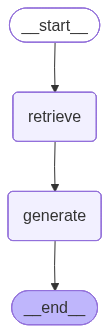

In [51]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [52]:
query = "연봉 5천만원인 거주자의 소득세는 얼마인가요?"
initial_state = {'query': query}

graph.invoke(initial_state)

{'query': '연봉 5천만원인 거주자의 소득세는 얼마인가요?',
 'context': [Document(id='f5c74d69-d34a-4bfe-80aa-e6ccbc22c35a', metadata={'source': '/Users/ksj/MyProjects/llm/inflearn-langgrath-lecture/docs/income_tax.txt'}, page_content='② 제70조제1항, 제70조의2에 따른 제74조에 따라 차례로 할 것이 제70조제1항제2호에 따르며 서류를 제출하여야 한다는 경우에는 기준소득 중 거주자 본인이 된다(분산)과 제70조제2와 제74조에 따른 제료 및 제대법을 포함한다. 단, 차별제표청정인 그 업체를 남겨 제출한 경우로 그에 대하여 아니하다.<개정 2013. 1. 1.>\n  ③ 제80조에 따른 수익과 관련의 경우에는 기초공제 중 거주자 본인이 된다(분산)과 그에 관한 적지사항을 분명히 한다.\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제54조의2(공동사업에 대한 소득공제 등 특례) 제51조의3 또는 「조세특례제한법」에 따른 소득공제를 적용하거나 제59조의2에 따른 세액감면을 적용하는 경우 제54조제3항에 따라 공동사업자의 소득에 합산과세되는 특별세액거래의 지출․납입․투자 등의 금액이 있을 경우 주된 공동사업자의 소득에 합산과세되는 소득금액에 합산되어 주된 공동사업자의 합산과세세액은 공동사업소득액 또는 공동사업창출세액을 계산할 때 소득공제 또는 세액공제를 받을 수 있다. \n[개정 2014. 1. 1.]\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제2절 세액의 계산 <개정 2009. 12. 31.>\n제1관 세율 <개정 2009. 12. 31.>\n제55조(세율) 거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 "종합소득과세표준세액"이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 